Importing packages

In [45]:
# import
import pandas as pd
import numpy as np
import seaborn as sns
# data vizualisation
import matplotlib.pyplot as plt
# model training
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
# text cleaning
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re

Loading CSV file

In [46]:
tweet = pd.read_csv("Tweets.csv")
tweet.head(3)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative


In [47]:
tweet.shape

(27481, 4)

Data cleaning

In [48]:
# dropping unusefull columns
tweet = tweet.drop(columns=['textID', 'selected_text'], axis=1)
tweet.shape

(27481, 2)

In [49]:
#checking for missing values
tweet.isnull().sum()

text         1
sentiment    0
dtype: int64

In [50]:
# show the content of the row that include a missing value
rows_with_missing_values = tweet[tweet.isnull().any(axis=1)]
print(rows_with_missing_values)

    text sentiment
314  NaN   neutral


In [51]:
# drop any missing value
tweet = tweet.dropna()
tweet.shape

(27480, 2)

In [52]:
# check for duplicate record
print('Number of duplicate Record:', tweet.duplicated().sum())

Number of duplicate Record: 0


Data vizualisation

Text(0.5, 1.0, 'Sentiment distribution')

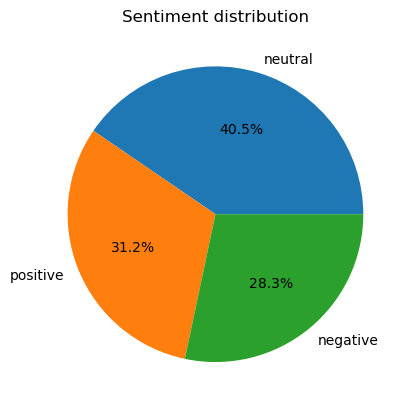

In [53]:
# check sentiments repartition
# using a pie plot
sentiment_count = tweet['sentiment'].value_counts()
plt.pie(sentiment_count, labels = sentiment_count.index, autopct='%1.1f%%')
plt.title('Sentiment distribution')

Cleaning all tweets

In [54]:
# replace sentiment string values by numerical values
# 0 for negative, 1 for neutral and 2 for positive
tweet.replace({'sentiment':{'negative':0, 'neutral':1, 'positive':2}}, inplace=True)
tweet.head()

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


In [55]:
# put every tweets to lower case
tweet['text']=tweet['text'].str.lower()
tweet.head()

,text,sentiment
0,"i`d have responded, if i were going",1
1,sooo sad i will miss you here in san diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"sons of ****, why couldn`t they put them on t...",0


In [56]:
# Download NLTK stop words and tokenizer
nltk.download('stopwords')
nltk.download('punkt')

# Function to remove URLs, numeric numbers, stop words, punctuation, and repeating characters, and tokenize the text
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    punctuation = string.punctuation
    
    # Remove URLs and numeric numbers
    text = re.sub(r'http\S+|www\S+|https\S+|\b\d+\b', '', text, flags=re.MULTILINE)
    
    # Tokenize the text
    word_tokens = word_tokenize(text)
    
    # Remove stop words, punctuation, and repeating characters
    cleaned_tokens = [re.sub(r'(.)\1+', r'\1', word.lower()) for word in word_tokens if word.lower() not in stop_words and word not in punctuation]
    
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

# Apply the function to the 'text' column
tweet['text'] = tweet['text'].apply(clean_text)
tweet['text'].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\martj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\martj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0                     responded going
1                so sad mis san diego
2                       bos bulying .
3               interview leave alone
4    sons put releases already bought
Name: text, dtype: object

In [57]:
nltk.download('wordnet')

# Function to lemmatize the text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in word_tokenize(text)]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

tweet['text'] = tweet['text'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\martj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [58]:
x=tweet.text
y=tweet.sentiment

In [59]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.1, random_state = 42)

In [60]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [61]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [62]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Neutral','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values")
    plt.ylabel("Actual values")
    plt.title ("Confusion Matrix")

              precision    recall  f1-score   support

           0       0.79      0.06      0.10       748
           1       0.45      0.97      0.62      1141
           2       0.88      0.27      0.42       859

    accuracy                           0.50      2748
   macro avg       0.71      0.43      0.38      2748
weighted avg       0.68      0.50      0.41      2748



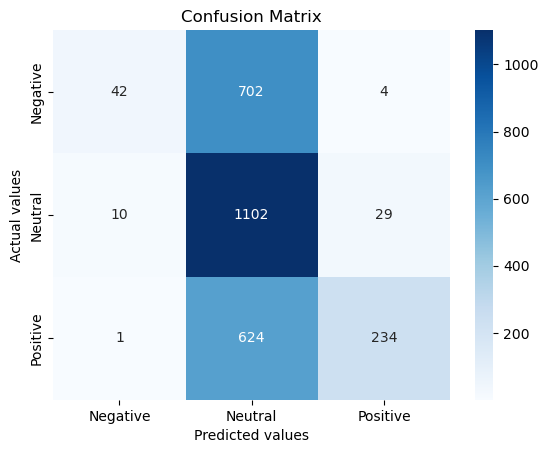

In [63]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

c:\Users\martj\miniconda3\envs\py38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.66      0.66      0.66       748
           1       0.69      0.64      0.66      1141
           2       0.72      0.79      0.76       859

    accuracy                           0.69      2748
   macro avg       0.69      0.70      0.69      2748
weighted avg       0.69      0.69      0.69      2748



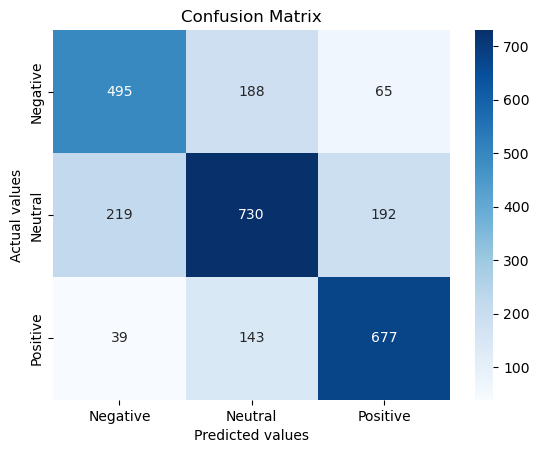

In [64]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

              precision    recall  f1-score   support

           0       0.69      0.62      0.65       748
           1       0.67      0.70      0.68      1141
           2       0.75      0.78      0.76       859

    accuracy                           0.70      2748
   macro avg       0.70      0.70      0.70      2748
weighted avg       0.70      0.70      0.70      2748



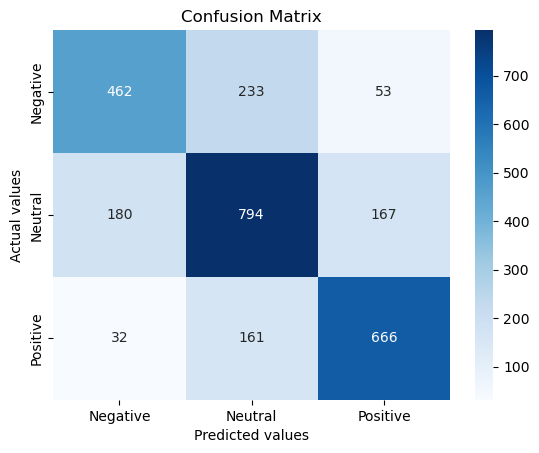

In [65]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)